In [11]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

In [12]:
model_fname = 'twitter_BERT'
my_wd = 'best/'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [13]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [25]:
df = pd.read_csv("real_dataset.csv",
encoding='ISO-8859-1', 
                 names=[
                        'target',
                        'text'
                        ])

In [27]:
df.head(
)

,target,text
0,0,penampilan nya gk seperti keliatannya
1,0,barang busuk sekali
2,0,ga tepat waktu
3,0,Gak Sesuai Deskripsi
4,0,tak sesuai gambar


In [23]:
sample_size = int(len(df)*1)
sampleDf = df.sample(sample_size, random_state=42) 
x = sampleDf.text.values
y = sampleDf.target.values
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.20, random_state=32, stratify=y)  

In [24]:
x_test2

array(['barang lecet lecet',
       'lama dikirim namun akan lebih baik apabila cepat dikirim',
       'barang gak dikirim', ...,
       'paket yg d kirim ga sesuai gambar slow respon',
       'kualitas gak bagus',
       'barang sesuai dengan pilihanharga murah tapi g murahan'],
      dtype=object)

In [3]:
max_seq_length = int(128)

In [4]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [10]:
X_train2 = bert_encode(x_train2, tokenizerSaved, max_seq_length)
X_test2 = bert_encode(x_test2, tokenizerSaved, max_seq_length)

In [20]:
x_test2[1]

'gpsnya rusak duluan sebelum dipake'

In [10]:
encoder_fname = 'twitter_classes.npy'
my_wd = 'best/'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

encoded_Y_test2 = encoder.transform(y_test2)
encoded_Y_train2 = encoder.transform(y_train2)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test2 = np_utils.to_categorical(encoded_Y_test2)
dummy_y_train2 = np_utils.to_categorical(encoded_Y_train2)

NameError: name 'y_test2' is not defined

In [67]:
loss, accuracy = new_model.evaluate(X_test2, dummy_y_test2, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

KeyboardInterrupt: 

In [25]:
y_predicted = new_model.predict(X_test2)
# y_predicted = y_predicted.flatten()

print(y_predicted.shape)


print(dummy_y_test2.shape)

204/204 [==============================] - 1422s 7s/step
(6512, 2)
(6512, 2)


In [26]:
# y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted = y_predicted.argmax(axis=1)
print(y_predicted)

dummy_y_test2 = dummy_y_test2.argmax(axis=1)
print(dummy_y_test2)

[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]


In [27]:
print(y_predicted.shape)
print(dummy_y_test2.shape)

(6512,)
(6512,)


In [28]:
# dummy_y_test2 = dummy_y_test2.flatten()
cm = confusion_matrix(dummy_y_test2, y_predicted)
cm

array([[3007,  249],
       [ 319, 2937]], dtype=int64)

Text(33.0, 0.5, 'Truth')

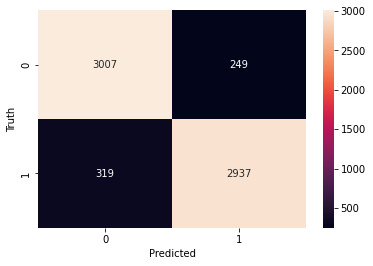

In [29]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [30]:
print(classification_report(dummy_y_test2, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      3256
           1       0.92      0.90      0.91      3256

    accuracy                           0.91      6512
   macro avg       0.91      0.91      0.91      6512
weighted avg       0.91      0.91      0.91      6512



In [7]:
encoder_fname = 'twitter_classes.npy'
my_wd = 'best/'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

In [13]:
tweet = ['ini barang apaan ballikin uang gue woyy']
inputs = bert_encode(string_list=list(tweet), 
                     tokenizer=tokenizerSaved, 
                     max_seq_length=128)

prediction = new_model.predict(inputs)
prediction = np.round(prediction,5)
print(tweet)
print(prediction)
print('Tweet is', 'positive' if encoder.classes_[np.argmax(prediction)]==1 else 'negative')

1/1 [==============================] - 0s 308ms/step
['ini barang apaan ballikin uang gue woyy']
[[9.9998e-01 2.0000e-05]]
Tweet is negative


In [ ]:
inputs